# Packages

In [1]:
#basic packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
from datetime import datetime


#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


import shap

In [2]:
#linear models packages
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# from yellowbrick.regressor import PredictionError, ResidualsPlot

#PCA
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

# Script

## Errors computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
#errors computation

def errors_computation(data):
    
    df=pd.DataFrame()
    df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    return df

In [5]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('')

In [6]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    
    x=power_curve['Wind Speed [m/s]']
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [7]:
def control_power_computation (data_test, data_train, power_curve):
    
    results_test=pd.DataFrame()
    results_train=pd.DataFrame()
    
    
    results_test=powercurve_computation(data_test, power_curve)
    results_train=powercurve_computation(data_train, power_curve)

    return results_test, results_train

In [8]:
def compute_results(data_test, data_train, power_curve, plot):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    
    if plot:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    return print('Showing the results of the modelling: ')

## Data uploading

In [9]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [10]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

## Data selection

In [11]:
def data_selection(X_train, X_test, inputs):
    
    #this function returns the columns of the training and test sets in the inputs list
    
    X_train1 = pd.DataFrame()
    X_test1 = pd.DataFrame()
    
    
    X_train1 = X_train[inputs]
    X_test1 = X_test[inputs]

    
    return X_train1,X_test1
    

In [12]:
def data_drop(X_train, X_test, list_2drop):
    
    #this function returns the columns of the training and test sets in the inputs list

    X_train1 = X_train.drop(columns=list_2drop)
    X_test1 = X_test.drop(columns=list_2drop)

    
    
    return X_train1,X_test1

## Modelling

### Linear regression

In [13]:
def linear_regression(X_train, X_test, y_train, y_test, power_curve, plot):


    linr=LinearRegression()
    linr=linr.fit(X_train, y_train)

    y_pred_test=linr.predict(X_test)
    y_pred_train=linr.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    

    coefs=pd.DataFrame(linr.coef_.T, index=list(X_train.keys()), columns = ['Lin_reg coeffs'])
    
    coefs = coefs.sort_values(['Lin_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
        
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    
    compute_results(data_test, data_train, power_curve, plot)
    print('Linear regression & results performed')
    
    return linr

### Polynomial regression

In [14]:
def polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, power_curve, plot):
    
    
    X_poly = PolynomialFeatures_labeled(X_train,degree)
    X_poly_test = PolynomialFeatures_labeled(X_test,degree)
    
    if model=='linear':
        model_regression=linear_regression(X_poly, X_poly_test, y_train, y_test, power_curve, plot)
    elif model=='ridge':
        model_regression=ridgecv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, power_curve, plot)
    elif model=='lasso':
        model_regression=lassocv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, power_curve, plot)
    elif model=='elasticnet':
        model_regression=elasticnetcv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, l1_ratios, power_curve, plot)
    print('')
    
    print('Polynomial regression & results performed')
    
    return model_regression

In [15]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

### Ridge regression

In [16]:
def ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, power_curve, plot):
    

    ridgeCV=RidgeCV(alphas=alphas,
                   cv=cv).fit(X_train, y_train.values.ravel())

    y_pred_test=ridgeCV.predict(X_test)
    y_pred_train=ridgeCV.predict(X_train)
    
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', ridgeCV.alpha_)
    print('')
    
    
    coefs=pd.DataFrame(ridgeCV.coef_.T, index=list(X_train.keys()), columns = ['RidgeCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with RidgeCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    coefs = coefs.sort_values(['RidgeCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('RidgeCV regression & results performed')
    
    return ridgeCV


### Lasso regression

In [17]:
def lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, power_curve, plot):
    

    
    lassoCV=LassoCV(alphas=alphas,
                   cv=cv).fit(X_train, y_train.values.ravel())

    y_pred_test=lassoCV.predict(X_test)
    y_pred_train=lassoCV.predict(X_train)
    
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', lassoCV.alpha_)
    print('')
    
    
    coefs=pd.DataFrame(lassoCV.coef_.T, index=list(X_train.keys()), columns = ['LassoCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with LassoCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    coefs = coefs.sort_values(['LassoCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('LassoCV regression & results performed')
    
    
    return lassoCV

### ElasticNet regression

In [18]:
def elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, power_curve, plot):
    
#     The first machine learning model taken into consideration is the polynomial with
#     regularization. The regularization technique chosen is known as "Elastic Net" which
#     is a middle point between Ridge Regression and Lasso Regression.
#     When r=0--> Ridge
#     When r=1--> Lasso

    elasticNetCV= ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=cv,
                               max_iter=1e4).fit(X_train, y_train.values.ravel())

    y_pred_test=elasticNetCV.predict(X_test)
    y_pred_train=elasticNetCV.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', elasticNetCV.alpha_)
    print('')
    print('Best l1_ratio: ' , elasticNetCV.l1_ratio_)
    
    
    coefs=pd.DataFrame(elasticNetCV.coef_.T, index=list(X_train.keys()), columns = ['ElasticNetCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with ElasticNetCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    
    coefs = coefs.sort_values(['ElasticNetCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('ElasticNetCV regression & results performed')
    
    return elasticNetCV

## Feature importance

In [19]:
def feature_importance (X_train, X_test, model):
    

    X100=shap.utils.sample(X_test, 100)
    
    explainer = shap.Explainer(model.predict, X100)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    shap.plots.beeswarm(shap_values)
    
    
    print('Feature importance through SHAP values performed')
    
    return shap_values

In [20]:
def transform_shap (shap_values, X_test):

    v=np.array(shap_values.values)
    d=v.reshape(X_test.shape)
    shap_v=pd.DataFrame(d)
    
    feature_list=X_test.columns
    shap_v.columns=feature_list
    shap_v=shap_v.abs()
    k=pd.DataFrame(shap_v.mean()).reset_index()
    k.columns=['variables','SHAP_abs']
    k.sort_values(by='variables')
    
    return k

# Data analysis

## Dataset2- T11

In [21]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
X_train= uploading_csv('\General','\X_train2.csv')
X_test= uploading_csv('\General','\X_test11.csv')
y_train= uploading_csv('\General','\y_train2.csv')
y_test= uploading_csv('\General','\y_test11.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'RH1',
       'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [22]:
y_test.keys()

Index(['Target'], dtype='object')

In [23]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V117.csv')

In [26]:
X_train=X_train.drop(columns=['RH1'])
X_test=X_test.drop(columns=['RH1'])

### Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.002 m/s as root mean
Wind MAE:  0.76 m/s in avg
Wind MAPE:  10.088 %
Power RMSE:  409.074 kW as root mean
Power MAE:  258.492 kW in avg
Power MAPE:  6.378314911801526e+17 %

Modelling errors for test set:
Wind RMSE:  0.972 m/s as root mean
Wind MAE:  0.721 m/s in avg
Wind MAPE:  10.381 %
Power RMSE:  340.418 kW as root mean
Power MAE:  193.81 kW in avg
Power MAPE:  1.1527081938079677e+18 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

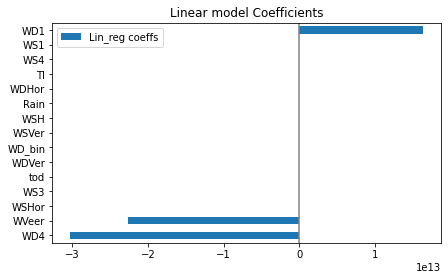

In [27]:
#results with all the variables

linear_regression(X_train, X_test, y_train, y_test, PC, plot=False)

### Polynomial Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.849 m/s as root mean
Wind MAE:  0.635 m/s in avg
Wind MAPE:  8.674 %
Power RMSE:  343.265 kW as root mean
Power MAE:  211.385 kW in avg
Power MAPE:  6.282203156084205e+17 %

Modelling errors for test set:
Wind RMSE:  0.876 m/s as root mean
Wind MAE:  0.644 m/s in avg
Wind MAPE:  9.506 %
Power RMSE:  307.515 kW as root mean
Power MAE:  173.707 kW in avg
Power MAPE:  1.16108174494715e+18 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

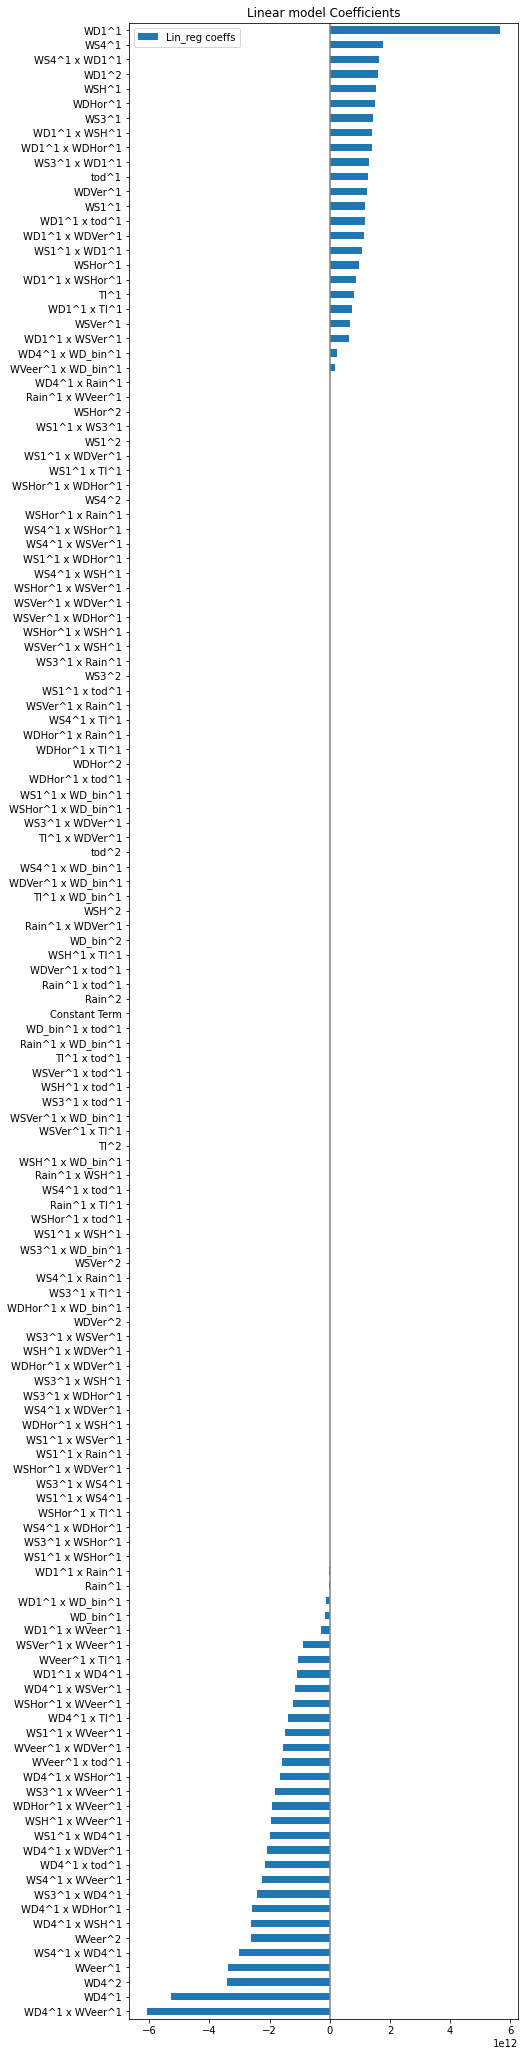

In [28]:
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Ridge regression

Best alpha:  0.0003

Of 15 coefficients, 15 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.002 m/s as root mean
Wind MAE:  0.76 m/s in avg
Wind MAPE:  10.097 %
Power RMSE:  409.056 kW as root mean
Power MAE:  258.481 kW in avg
Power MAPE:  6.383847321889718e+17 %

Modelling errors for test set:
Wind RMSE:  0.973 m/s as root mean
Wind MAE:  0.722 m/s in avg
Wind MAPE:  10.396 %
Power RMSE:  340.898 kW as root mean
Power MAE:  194.109 kW in avg
Power MAPE:  1.1537440746568118e+18 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([3.0e-04, 4.0e-04, 5.0e-04, 1.0e-03, 3.0e-03, 5.0e-03, 1.0e-02,
       3.0e-02, 5.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 1.0e+01, 5.0e+01,
       8.0e+01, 1.2e+02, 3.0e+02, 5.0e+02]),
        cv=4)

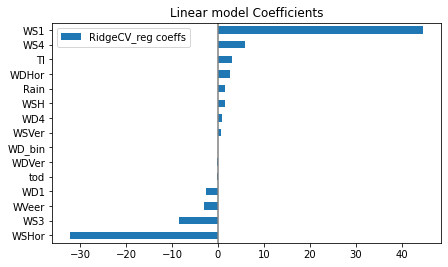

In [29]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Ridge regression

Best alpha:  0.0003

Of 136 coefficients, 135 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.851 m/s as root mean
Wind MAE:  0.636 m/s in avg
Wind MAPE:  8.688 %
Power RMSE:  343.974 kW as root mean
Power MAE:  211.783 kW in avg
Power MAPE:  6.277835892172317e+17 %

Modelling errors for test set:
Wind RMSE:  0.878 m/s as root mean
Wind MAE:  0.646 m/s in avg
Wind MAPE:  9.521 %
Power RMSE:  308.569 kW as root mean
Power MAE:  174.216 kW in avg
Power MAPE:  1.1579638294258086e+18 %

Showing the results of the modelling: 

RidgeCV regression & results performed

Polynomial regression & results performed


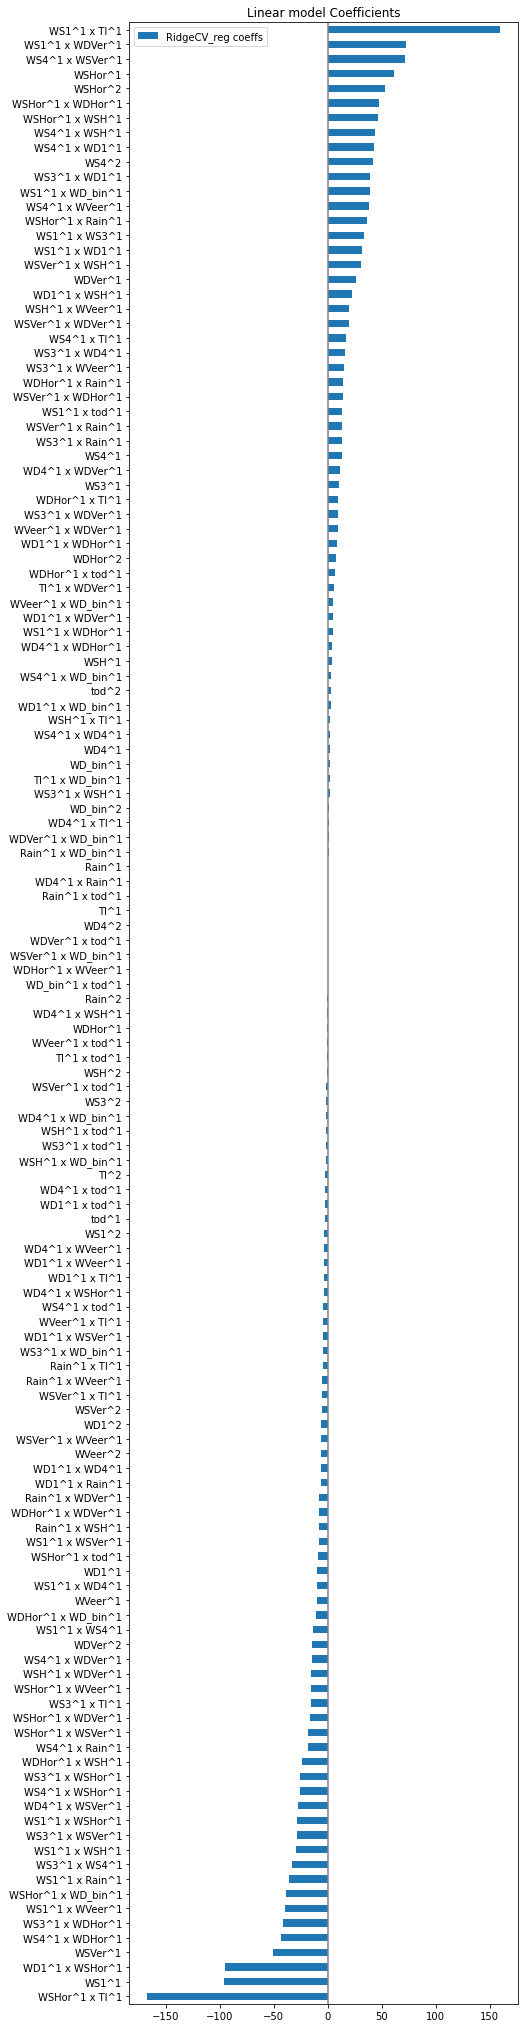

In [30]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='ridge'
cv=4
l1_ratios=None



model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC,plot=False)

### Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.86736839464902, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.9901553042, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.1524988212295, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 262.6788322405955, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.9618270496685, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 858.1315703208893, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.67063584637435, tolerance: 9.375337256756692
Objecti

Best alpha:  0.0003

Of 15 coefficients, 12 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.015 m/s as root mean
Wind MAE:  0.773 m/s in avg
Wind MAPE:  10.193 %
Power RMSE:  413.141 kW as root mean
Power MAE:  261.444 kW in avg
Power MAPE:  6.335162916193204e+17 %

Modelling errors for test set:
Wind RMSE:  0.989 m/s as root mean
Wind MAE:  0.737 m/s in avg
Wind MAPE:  10.535 %
Power RMSE:  346.609 kW as root mean
Power MAE:  198.303 kW in avg
Power MAPE:  1.163579798308473e+18 %

Showing the results of the modelling: 

LassoCV regression & results performed


Objective did not converge. You might want to increase the number of iterations. Duality gap: 2368.2591553432267, tolerance: 12.478561704380272


LassoCV(alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05,
                0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500],
        cv=4)

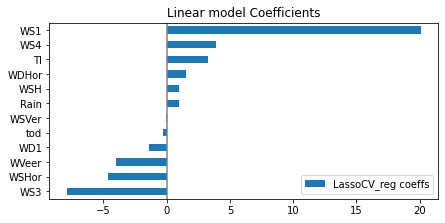

In [31]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Lasso regression

Best alpha:  0.001

Of 136 coefficients, 22 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.933 m/s as root mean
Wind MAE:  0.705 m/s in avg
Wind MAPE:  9.439 %
Power RMSE:  382.093 kW as root mean
Power MAE:  238.116 kW in avg
Power MAPE:  6.254124653138796e+17 %

Modelling errors for test set:
Wind RMSE:  0.939 m/s as root mean
Wind MAE:  0.695 m/s in avg
Wind MAPE:  10.144 %
Power RMSE:  341.49 kW as root mean
Power MAE:  193.981 kW in avg
Power MAPE:  1.213710449647331e+18 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50,
                80, 120, 300, 500],
        cv=4)

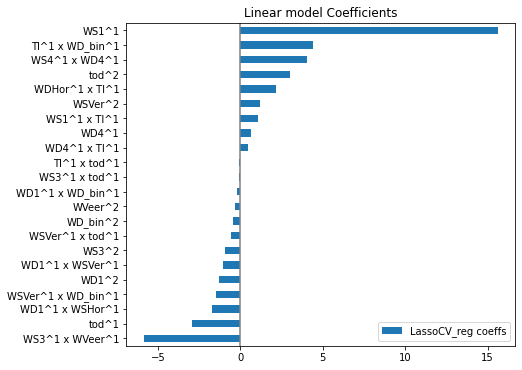

In [32]:
alphas=[0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### ElasticNet regression

Best alpha:  0.001

Best l1_ratio:  0.9
Of 15 coefficients, 11 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.032 m/s as root mean
Wind MAE:  0.789 m/s in avg
Wind MAPE:  10.344 %
Power RMSE:  420.16 kW as root mean
Power MAE:  266.489 kW in avg
Power MAPE:  6.35047699901025e+17 %

Modelling errors for test set:
Wind RMSE:  1.002 m/s as root mean
Wind MAE:  0.749 m/s in avg
Wind MAPE:  10.603 %
Power RMSE:  349.384 kW as root mean
Power MAE:  200.907 kW in avg
Power MAPE:  1.1616052500027162e+18 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

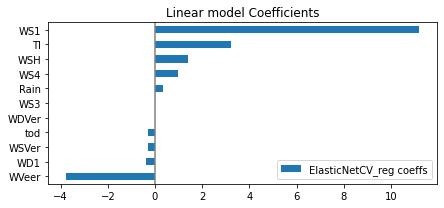

In [35]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

### Polynomial ElasticNet regression

Best alpha:  0.005

Best l1_ratio:  0.9
Of 136 coefficients, 22 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.996 m/s as root mean
Wind MAE:  0.764 m/s in avg
Wind MAPE:  10.05 %
Power RMSE:  403.093 kW as root mean
Power MAE:  256.351 kW in avg
Power MAPE:  6.33610825947336e+17 %

Modelling errors for test set:
Wind RMSE:  0.979 m/s as root mean
Wind MAE:  0.738 m/s in avg
Wind MAPE:  10.65 %
Power RMSE:  348.712 kW as root mean
Power MAE:  203.527 kW in avg
Power MAPE:  1.1831246698644936e+18 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=array([5.0e-03, 5.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 2.0e+01, 5.0e+01,
       8.0e+01, 1.0e+02, 1.2e+02, 1.4e+02]),
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

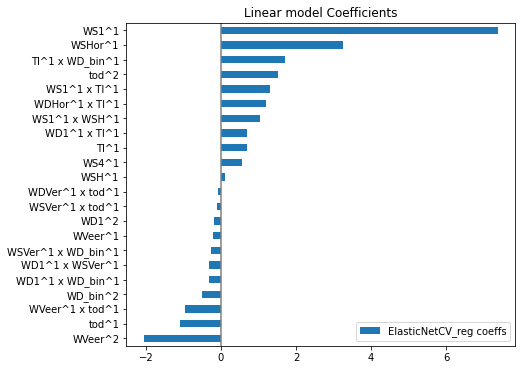

In [36]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=np.array([0.005, 0.05, 0.1, 1, 5, 20, 50, 80, 100, 120, 140])
degree=2
model='elasticnet'
cv=4



polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

## Dataset2- T17

In [37]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\General','\X_train2.csv')
X_test= uploading_csv('\General','\X_test17.csv')
y_train= uploading_csv('\General','\y_train2.csv')
y_test= uploading_csv('\General','\y_test17.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'RH1',
       'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [38]:
y_test.keys()

Index(['Target'], dtype='object')

In [39]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V112.csv')

In [40]:
X_train=X_train.drop(columns=['RH1'])
X_test=X_test.drop(columns=['RH1'])

### Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.002 m/s as root mean
Wind MAE:  0.76 m/s in avg
Wind MAPE:  10.088 %
Power RMSE:  405.464 kW as root mean
Power MAE:  262.888 kW in avg
Power MAPE:  6.221856897493745e+17 %

Modelling errors for test set:
Wind RMSE:  0.809 m/s as root mean
Wind MAE:  0.635 m/s in avg
Wind MAPE:  6.921 %
Power RMSE:  321.053 kW as root mean
Power MAE:  219.004 kW in avg
Power MAPE:  16.095 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

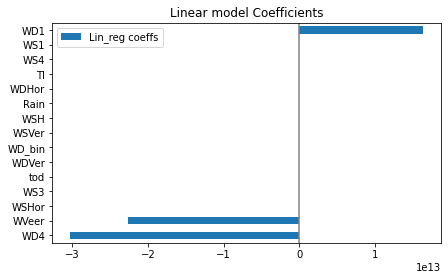

In [41]:
#results with all the variables
linear_regression(X_train, X_test, y_train, y_test, PC, plot=False)

### Polynomial Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.849 m/s as root mean
Wind MAE:  0.635 m/s in avg
Wind MAPE:  8.674 %
Power RMSE:  339.242 kW as root mean
Power MAE:  215.067 kW in avg
Power MAPE:  6.132629374805768e+17 %

Modelling errors for test set:
Wind RMSE:  0.666 m/s as root mean
Wind MAE:  0.514 m/s in avg
Wind MAPE:  5.713 %
Power RMSE:  277.478 kW as root mean
Power MAE:  178.519 kW in avg
Power MAPE:  13.589 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


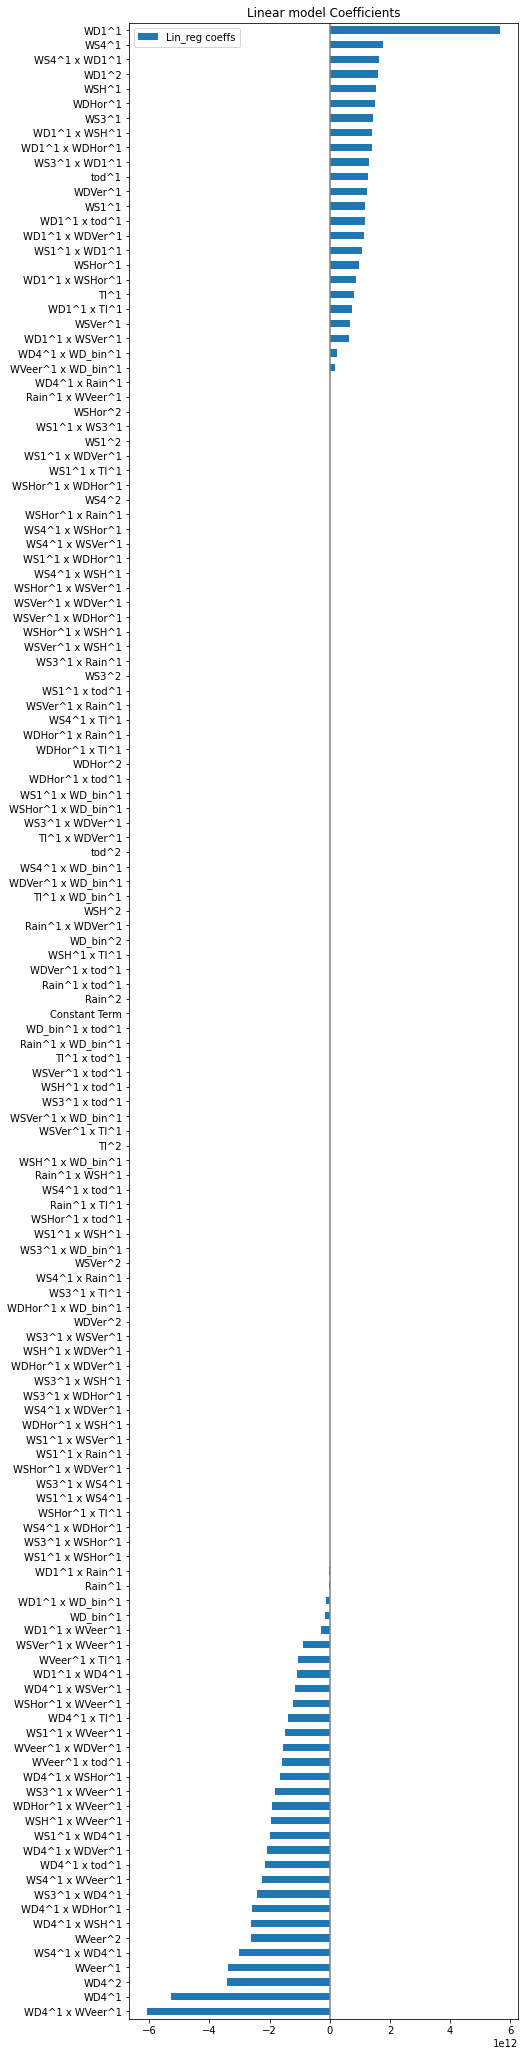

In [42]:
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Ridge regression

Best alpha:  0.0003

Of 15 coefficients, 15 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.002 m/s as root mean
Wind MAE:  0.76 m/s in avg
Wind MAPE:  10.097 %
Power RMSE:  405.411 kW as root mean
Power MAE:  262.863 kW in avg
Power MAPE:  6.228679596227146e+17 %

Modelling errors for test set:
Wind RMSE:  0.808 m/s as root mean
Wind MAE:  0.635 m/s in avg
Wind MAPE:  6.919 %
Power RMSE:  320.839 kW as root mean
Power MAE:  218.828 kW in avg
Power MAPE:  16.11 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([3.0e-04, 4.0e-04, 5.0e-04, 1.0e-03, 3.0e-03, 5.0e-03, 1.0e-02,
       3.0e-02, 5.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 1.0e+01, 5.0e+01,
       8.0e+01, 1.2e+02, 3.0e+02, 5.0e+02]),
        cv=4)

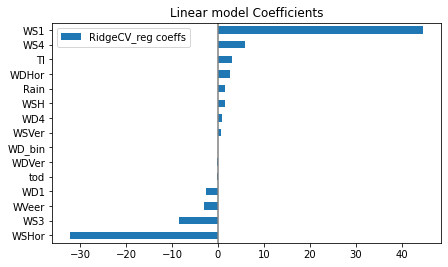

In [43]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Ridge regression

Best alpha:  0.0003

Of 136 coefficients, 135 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.851 m/s as root mean
Wind MAE:  0.636 m/s in avg
Wind MAPE:  8.688 %
Power RMSE:  340.038 kW as root mean
Power MAE:  215.531 kW in avg
Power MAPE:  6.130087958220347e+17 %

Modelling errors for test set:
Wind RMSE:  0.659 m/s as root mean
Wind MAE:  0.514 m/s in avg
Wind MAPE:  5.714 %
Power RMSE:  274.917 kW as root mean
Power MAE:  178.829 kW in avg
Power MAPE:  13.613 %

Showing the results of the modelling: 

RidgeCV regression & results performed

Polynomial regression & results performed


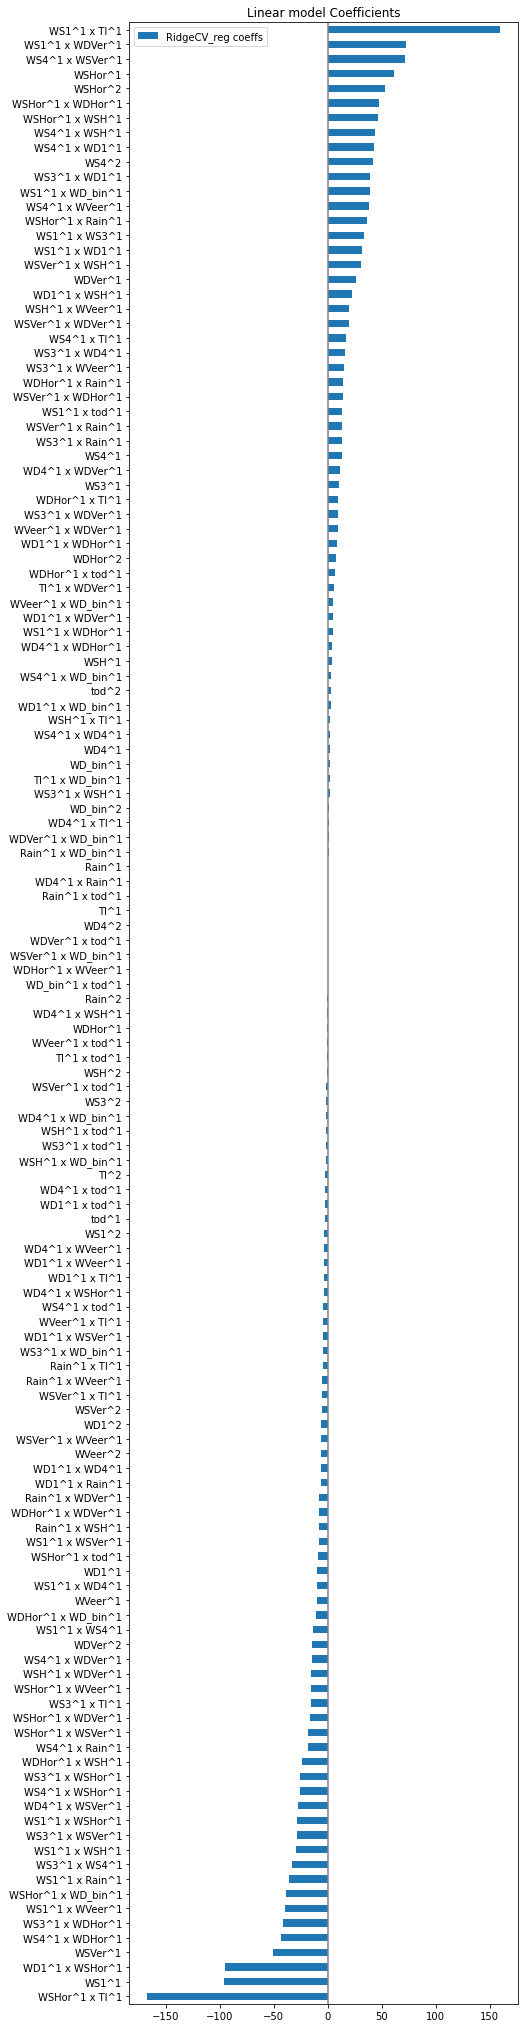

In [44]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='ridge'
cv=4
l1_ratios=None


model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.86736839464902, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.9901553042, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.1524988212295, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 262.6788322405955, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.9618270496685, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 858.1315703208893, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.67063584637435, tolerance: 9.375337256756692
Objecti

Best alpha:  0.0003

Of 15 coefficients, 12 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.015 m/s as root mean
Wind MAE:  0.773 m/s in avg
Wind MAPE:  10.193 %
Power RMSE:  409.866 kW as root mean
Power MAE:  266.223 kW in avg
Power MAPE:  6.164879863066808e+17 %

Modelling errors for test set:
Wind RMSE:  0.785 m/s as root mean
Wind MAE:  0.625 m/s in avg
Wind MAPE:  6.856 %
Power RMSE:  313.8 kW as root mean
Power MAE:  213.261 kW in avg
Power MAPE:  16.119 %

Showing the results of the modelling: 

LassoCV regression & results performed


Objective did not converge. You might want to increase the number of iterations. Duality gap: 2368.2591553432267, tolerance: 12.478561704380272


LassoCV(alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05,
                0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500],
        cv=4)

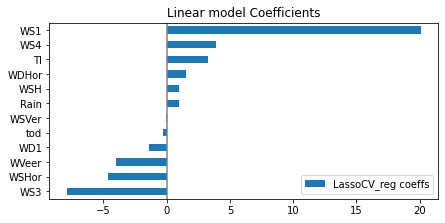

In [45]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.4823549812445, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.1423186299853, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 157.09564289611262, tolerance: 9.375337256756692
Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.52643632788386, tolerance: 9.35949100105578
Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.847724107226895, tolerance: 12.478561704380272


Best alpha:  0.0005

Of 136 coefficients, 36 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.913 m/s as root mean
Wind MAE:  0.686 m/s in avg
Wind MAPE:  9.232 %
Power RMSE:  370.488 kW as root mean
Power MAE:  235.947 kW in avg
Power MAPE:  6.096068558674176e+17 %

Modelling errors for test set:
Wind RMSE:  0.713 m/s as root mean
Wind MAE:  0.563 m/s in avg
Wind MAPE:  6.219 %
Power RMSE:  301.17 kW as root mean
Power MAE:  197.277 kW in avg
Power MAPE:  14.656 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5,
                10, 50, 80, 120, 300, 500],
        cv=4)

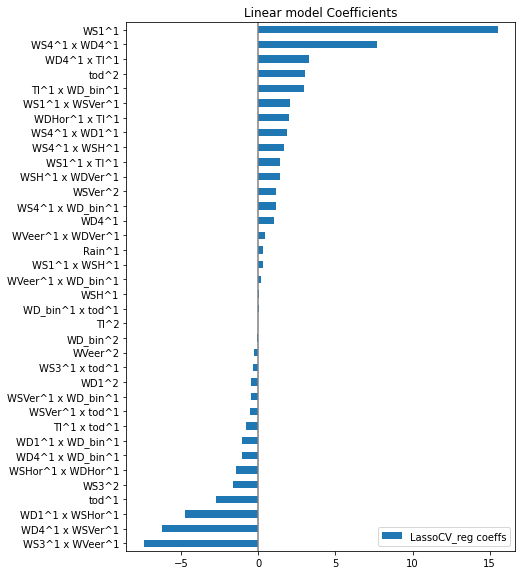

In [46]:
alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv,  alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### ElasticNet regression

Best alpha:  0.001

Best l1_ratio:  0.9
Of 15 coefficients, 11 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.032 m/s as root mean
Wind MAE:  0.789 m/s in avg
Wind MAPE:  10.344 %
Power RMSE:  417.215 kW as root mean
Power MAE:  271.559 kW in avg
Power MAPE:  6.179526083847931e+17 %

Modelling errors for test set:
Wind RMSE:  0.818 m/s as root mean
Wind MAE:  0.652 m/s in avg
Wind MAPE:  7.159 %
Power RMSE:  326.409 kW as root mean
Power MAE:  220.756 kW in avg
Power MAPE:  16.891 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

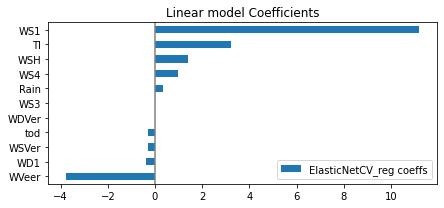

In [47]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

Best alpha:  0.0005

Best l1_ratio:  0.9
Of 15 coefficients, 11 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.024 m/s as root mean
Wind MAE:  0.781 m/s in avg
Wind MAPE:  10.265 %
Power RMSE:  413.425 kW as root mean
Power MAE:  268.694 kW in avg
Power MAPE:  6.170934361616207e+17 %

Modelling errors for test set:
Wind RMSE:  0.801 m/s as root mean
Wind MAE:  0.638 m/s in avg
Wind MAPE:  6.998 %
Power RMSE:  319.933 kW as root mean
Power MAE:  216.587 kW in avg
Power MAPE:  16.456 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

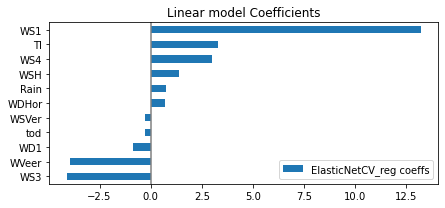

In [48]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

### Polynomial ElasticNet regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.20280716211346, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.37262871649727, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.92057606880189, tolerance: 9.375337256756692
Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.05764859041483, tolerance: 9.35949100105578
Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.698639168851514, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.041525518201524, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.20986019307202, tolerance: 9.375337256756692
Objec

Best alpha:  0.0005

Best l1_ratio:  0.9
Of 136 coefficients, 45 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.916 m/s as root mean
Wind MAE:  0.69 m/s in avg
Wind MAPE:  9.273 %
Power RMSE:  371.152 kW as root mean
Power MAE:  236.922 kW in avg
Power MAPE:  6.097856869982029e+17 %

Modelling errors for test set:
Wind RMSE:  0.72 m/s as root mean
Wind MAE:  0.569 m/s in avg
Wind MAPE:  6.282 %
Power RMSE:  304.027 kW as root mean
Power MAE:  199.108 kW in avg
Power MAPE:  14.838 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

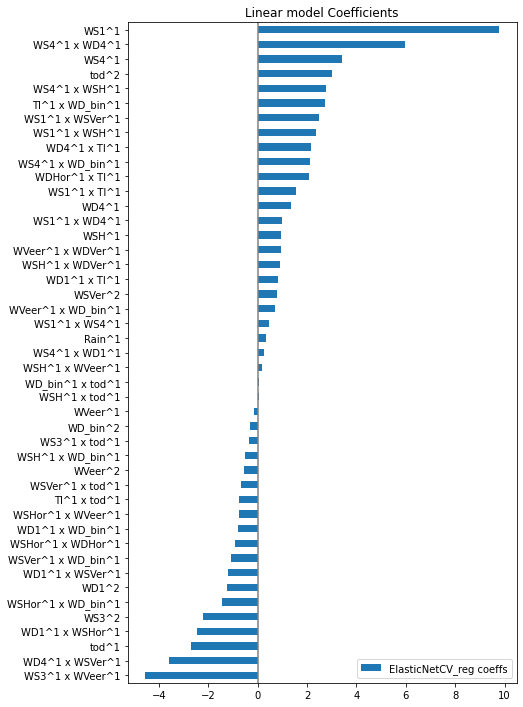

In [49]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
degree=2
model='elasticnet'
cv=4


polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

## Dataset2- T22

In [50]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\General','\X_train2.csv')
X_test= uploading_csv('\General','\X_test22.csv')
y_train= uploading_csv('\General','\y_train2.csv')
y_test= uploading_csv('\General','\y_test22.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'RH1',
       'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [51]:
y_test.keys()

Index(['Target'], dtype='object')

In [52]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V117.csv')

In [53]:
X_train=X_train.drop(columns=['RH1'])
X_test=X_test.drop(columns=['RH1'])

### Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.002 m/s as root mean
Wind MAE:  0.76 m/s in avg
Wind MAPE:  10.088 %
Power RMSE:  409.074 kW as root mean
Power MAE:  258.492 kW in avg
Power MAPE:  6.378314911801526e+17 %

Modelling errors for test set:
Wind RMSE:  1.188 m/s as root mean
Wind MAE:  0.931 m/s in avg
Wind MAPE:  11.851 %
Power RMSE:  536.504 kW as root mean
Power MAE:  384.563 kW in avg
Power MAPE:  41.051 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

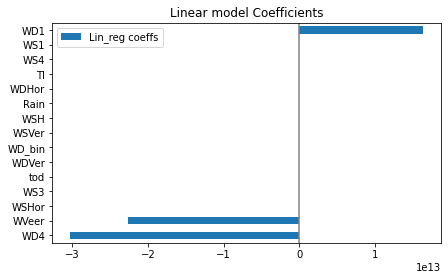

In [54]:
#results with all the variables
linear_regression(X_train, X_test, y_train, y_test, PC, plot=False)

### Polynomial Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.849 m/s as root mean
Wind MAE:  0.635 m/s in avg
Wind MAPE:  8.674 %
Power RMSE:  343.265 kW as root mean
Power MAE:  211.385 kW in avg
Power MAPE:  6.282203156084205e+17 %

Modelling errors for test set:
Wind RMSE:  0.937 m/s as root mean
Wind MAE:  0.72 m/s in avg
Wind MAPE:  9.346 %
Power RMSE:  424.344 kW as root mean
Power MAE:  289.928 kW in avg
Power MAPE:  30.516 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


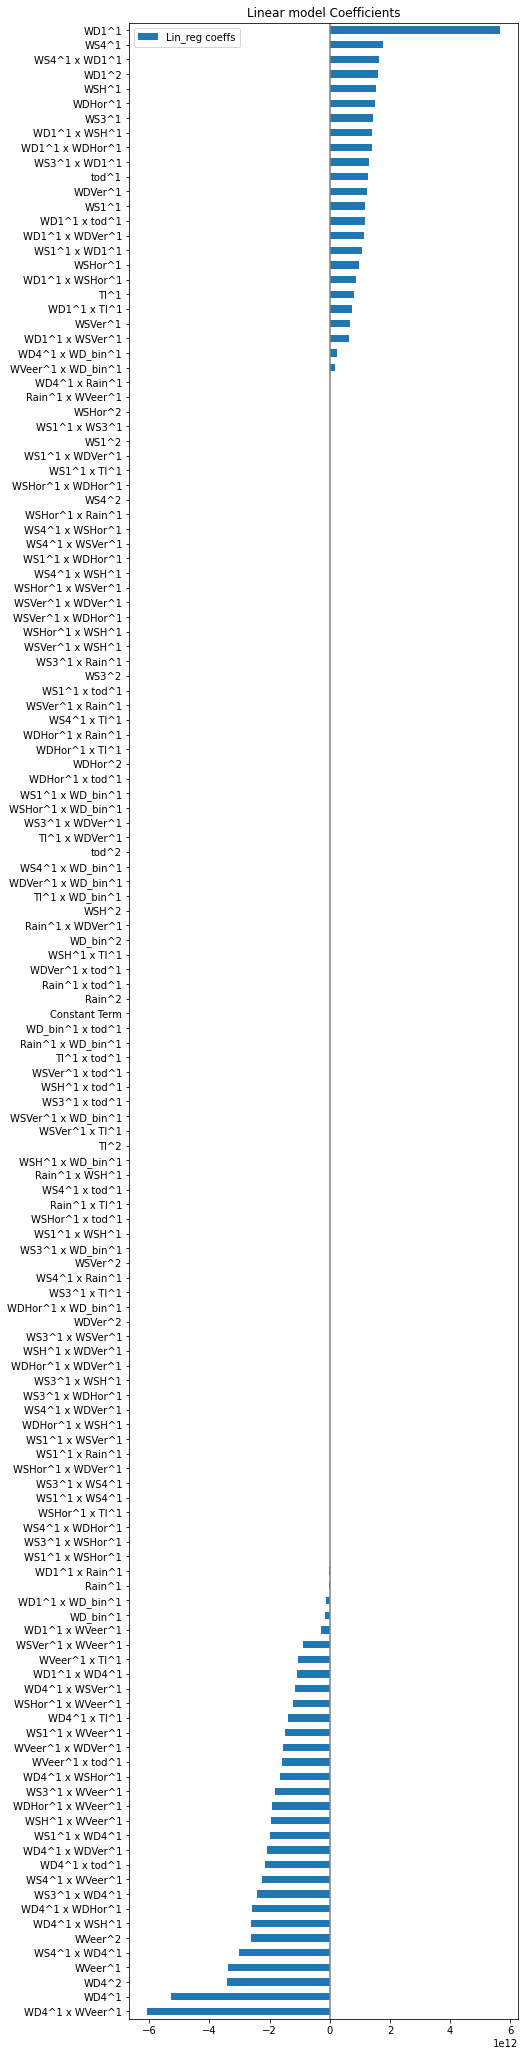

In [55]:
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Ridge regression

Best alpha:  0.0003

Of 15 coefficients, 15 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.002 m/s as root mean
Wind MAE:  0.76 m/s in avg
Wind MAPE:  10.097 %
Power RMSE:  409.056 kW as root mean
Power MAE:  258.481 kW in avg
Power MAPE:  6.383847321889718e+17 %

Modelling errors for test set:
Wind RMSE:  1.188 m/s as root mean
Wind MAE:  0.932 m/s in avg
Wind MAPE:  11.86 %
Power RMSE:  536.418 kW as root mean
Power MAE:  384.641 kW in avg
Power MAPE:  41.103 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([3.0e-04, 4.0e-04, 5.0e-04, 1.0e-03, 3.0e-03, 5.0e-03, 1.0e-02,
       3.0e-02, 5.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 1.0e+01, 5.0e+01,
       8.0e+01, 1.2e+02, 3.0e+02, 5.0e+02]),
        cv=4)

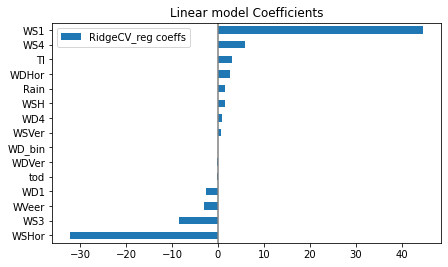

In [56]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Ridge regression

Best alpha:  0.0003

Of 136 coefficients, 135 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.851 m/s as root mean
Wind MAE:  0.636 m/s in avg
Wind MAPE:  8.688 %
Power RMSE:  343.974 kW as root mean
Power MAE:  211.783 kW in avg
Power MAPE:  6.277835892172317e+17 %

Modelling errors for test set:
Wind RMSE:  0.933 m/s as root mean
Wind MAE:  0.716 m/s in avg
Wind MAPE:  9.281 %
Power RMSE:  422.024 kW as root mean
Power MAE:  288.231 kW in avg
Power MAPE:  30.298 %

Showing the results of the modelling: 

RidgeCV regression & results performed

Polynomial regression & results performed


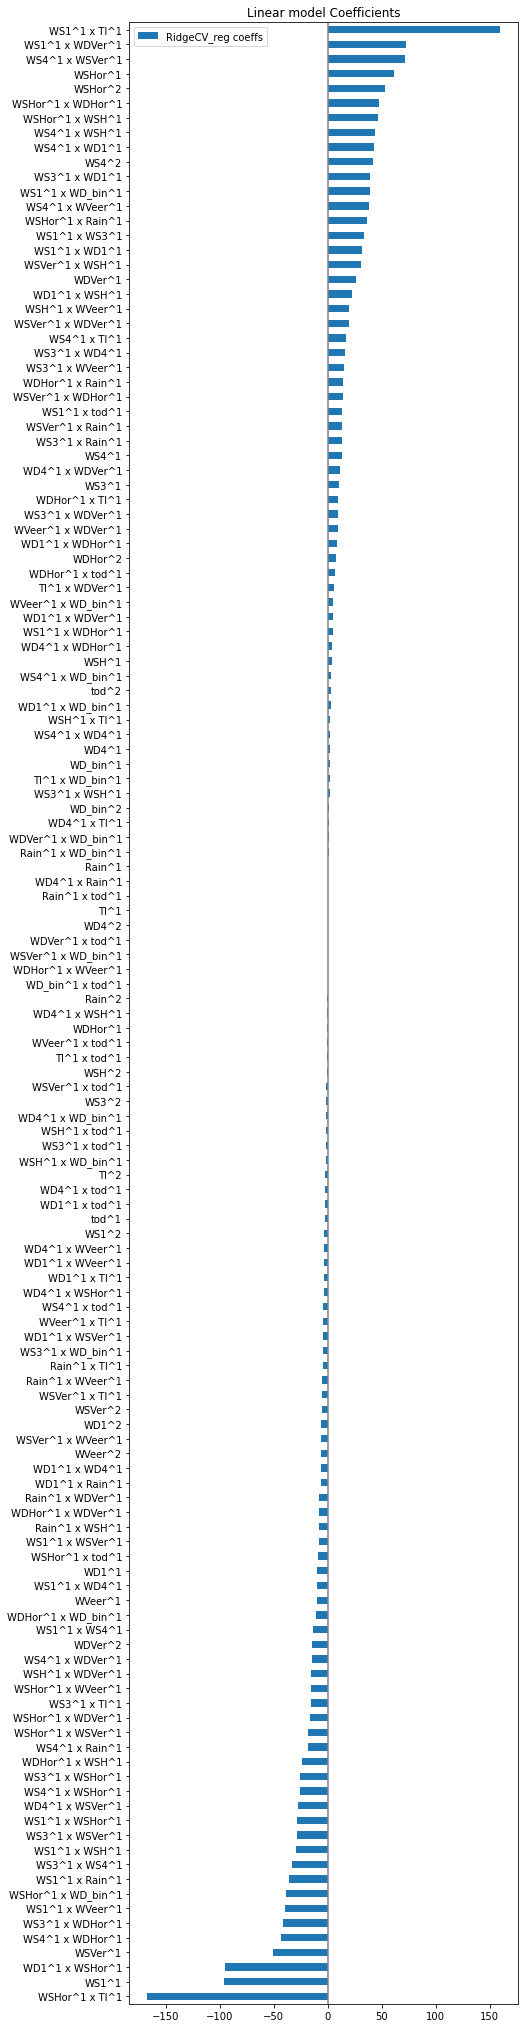

In [57]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='ridge'
cv=4
l1_ratios=None


model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.86736839464902, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.9901553042, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.1524988212295, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 262.6788322405955, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.9618270496685, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 858.1315703208893, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.67063584637435, tolerance: 9.375337256756692
Objecti

Best alpha:  0.0003

Of 15 coefficients, 12 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.015 m/s as root mean
Wind MAE:  0.773 m/s in avg
Wind MAPE:  10.193 %
Power RMSE:  413.141 kW as root mean
Power MAE:  261.444 kW in avg
Power MAPE:  6.335162916193204e+17 %

Modelling errors for test set:
Wind RMSE:  1.225 m/s as root mean
Wind MAE:  0.962 m/s in avg
Wind MAPE:  12.024 %
Power RMSE:  550.434 kW as root mean
Power MAE:  395.948 kW in avg
Power MAPE:  40.338 %

Showing the results of the modelling: 

LassoCV regression & results performed


Objective did not converge. You might want to increase the number of iterations. Duality gap: 2368.2591553432267, tolerance: 12.478561704380272


LassoCV(alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05,
                0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500],
        cv=4)

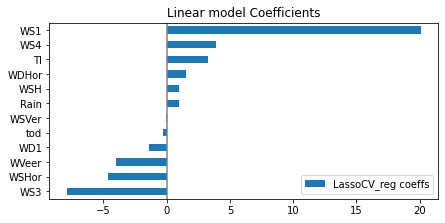

In [58]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.4823549812445, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 181.1423186299853, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 157.09564289611262, tolerance: 9.375337256756692
Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.52643632788386, tolerance: 9.35949100105578
Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.847724107226895, tolerance: 12.478561704380272


Best alpha:  0.0005

Of 136 coefficients, 36 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.913 m/s as root mean
Wind MAE:  0.686 m/s in avg
Wind MAPE:  9.232 %
Power RMSE:  374.357 kW as root mean
Power MAE:  231.693 kW in avg
Power MAPE:  6.249548793236497e+17 %

Modelling errors for test set:
Wind RMSE:  1.031 m/s as root mean
Wind MAE:  0.793 m/s in avg
Wind MAPE:  9.998 %
Power RMSE:  463.599 kW as root mean
Power MAE:  320.991 kW in avg
Power MAPE:  31.652 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5,
                10, 50, 80, 120, 300, 500],
        cv=4)

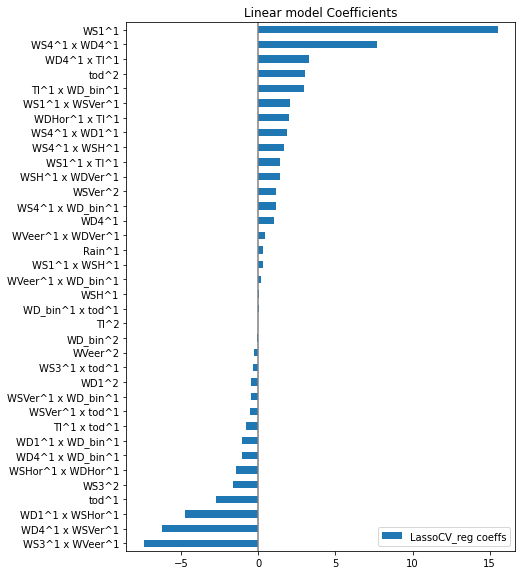

In [59]:
alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv,  alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### ElasticNet regression

Best alpha:  0.001

Best l1_ratio:  0.9
Of 15 coefficients, 11 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.032 m/s as root mean
Wind MAE:  0.789 m/s in avg
Wind MAPE:  10.344 %
Power RMSE:  420.16 kW as root mean
Power MAE:  266.489 kW in avg
Power MAPE:  6.35047699901025e+17 %

Modelling errors for test set:
Wind RMSE:  1.242 m/s as root mean
Wind MAE:  0.979 m/s in avg
Wind MAPE:  12.206 %
Power RMSE:  558.642 kW as root mean
Power MAE:  403.968 kW in avg
Power MAPE:  40.542 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

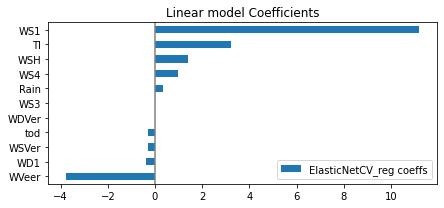

In [60]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

Best alpha:  0.0005

Best l1_ratio:  0.9
Of 15 coefficients, 11 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  1.024 m/s as root mean
Wind MAE:  0.781 m/s in avg
Wind MAPE:  10.265 %
Power RMSE:  416.558 kW as root mean
Power MAE:  263.758 kW in avg
Power MAPE:  6.342216220209233e+17 %

Modelling errors for test set:
Wind RMSE:  1.235 m/s as root mean
Wind MAE:  0.971 m/s in avg
Wind MAPE:  12.118 %
Power RMSE:  555.065 kW as root mean
Power MAE:  400.135 kW in avg
Power MAPE:  40.363 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

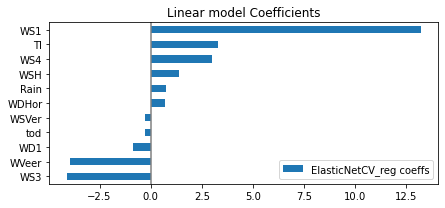

In [61]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

### Polynomial ElasticNet regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.20280716211346, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.37262871649727, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.92057606880189, tolerance: 9.375337256756692
Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.05764859041483, tolerance: 9.35949100105578
Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.698639168851514, tolerance: 9.387012419682831
Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.041525518201524, tolerance: 9.311255162801729
Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.20986019307202, tolerance: 9.375337256756692
Objec

Best alpha:  0.0005

Best l1_ratio:  0.9
Of 136 coefficients, 45 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.916 m/s as root mean
Wind MAE:  0.69 m/s in avg
Wind MAPE:  9.273 %
Power RMSE:  375.043 kW as root mean
Power MAE:  232.603 kW in avg
Power MAPE:  6.252517242060003e+17 %

Modelling errors for test set:
Wind RMSE:  1.032 m/s as root mean
Wind MAE:  0.797 m/s in avg
Wind MAPE:  10.042 %
Power RMSE:  462.515 kW as root mean
Power MAE:  321.587 kW in avg
Power MAPE:  31.676 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

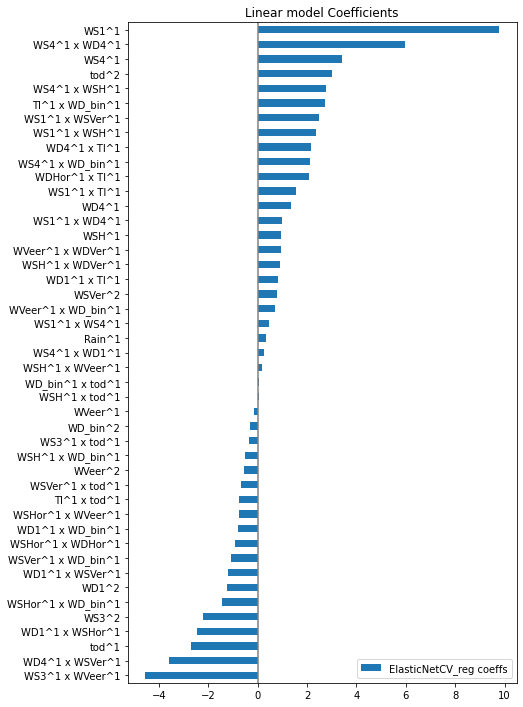

In [62]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
degree=2
model='elasticnet'
cv=4


polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)